In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import *
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import *
from catboost.utils import eval_metric
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from catboost.utils import get_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score

import tensorflow as tf

from deepctr.models import DeepFM, FiBiNET, AFM, DCN
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names
from eli5.sklearn import PermutationImportance
import itertools
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Lambda

Считываем данные и изучаем их

In [2]:
source_df = pd.read_csv("ds_homework_sample.csv", delimiter = '|', encoding='utf-8')
pd.set_option('display.max_columns', None)
source_df.head()

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions
0,2016-09-09 10:00:00,23051597.0,502713.0,492.0,4375553.0,2505762.0,BR,726.0,4162.0,4.0,mobile,android,android5,tablet,other,fb,pt,1.0,0.0,17111.0,0.0,f,BROADBAND,1.0,0.0
1,2016-09-05 14:00:00,23075994.0,8508.0,2287.0,13732852.0,6530828.0,RO,12074.0,512299.0,1.0,desktop,windows,win7,desktop,desktop,chrome,ro,2.0,0.0,88118.0,0.0,f,BROADBAND,1.0,0.0
2,2016-09-08 22:00:00,21359300.0,17528.0,NaN,12242731.0,5797966.0,EG,25295.0,29514.0,4.0,mobile,android,android6,tablet,other,chrome,en,6.0,0.0,102851.0,0.0,f,BROADBAND,1.0,0.0
3,2016-09-10 19:00:00,23074678.0,420481.0,2287.0,5388033.0,62457.0,JO,25649.0,12381.0,1.0,desktop,windows,win8,desktop,desktop,ie,en,2.0,0.0,105638.0,0.0,f,BROADBAND,1.0,0.0
4,2016-09-14 00:00:00,22289011.0,450621.0,NaN,11164447.0,3927.0,BR,10122.0,11105.0,1.0,desktop,windows,win10,desktop,desktop,chrome,pt,2.0,0.0,104045.0,0.0,f,BROADBAND,1.0,0.0


In [3]:
source_df.describe()

,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,region_code,city_code,varp,varpp,varcc,isp,mobile_isp,impressions,conversions
count,1.000000e+06,1000000.000000,392841.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.264680e+07,354552.960094,3374.746251,9.926060e+06,2.923421e+06,11851.493369,42163.557272,2.275994,7.402995,3.362308,62603.377787,150.680187,1.141711,0.003222
std,1.982658e+06,180463.517675,6818.807783,4.045644e+06,2.510900e+06,9588.111542,83139.782550,1.428842,35.712483,21.130401,39836.956394,374.811117,1.528504,0.058083
min,2.077594e+06,2173.000000,9.000000,4.214700e+04,3.927000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.234612e+07,305078.000000,356.000000,8.480536e+06,6.245700e+04,1320.000000,3202.750000,1.000000,1.000000,0.000000,21083.000000,0.000000,1.000000,0.000000
50%,2.326071e+07,351187.000000,492.000000,1.116445e+07,3.191506e+06,10130.000000,12463.000000,1.000000,2.000000,0.000000,71981.000000,0.000000,1.000000,0.000000
75%,2.395150e+07,488661.000000,2287.000000,1.301491e+07,5.288251e+06,23781.000000,35939.000000,4.000000,5.000000,1.000000,102851.000000,0.000000,1.000000,0.000000
max,2.436465e+07,645445.000000,30740.000000,1.490791e+07,7.048359e+06,34657.000000,618309.000000,5.000000,6772.000000,1644.000000,121355.000000,2358.000000,327.000000,7.000000


In [4]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date_time      1000001 non-null  object 
 1   banner_id      1000000 non-null  float64
 2   advertiser_id  1000000 non-null  float64
 3   offer_id       392841 non-null   float64
 4   zone_id        1000000 non-null  float64
 5   affiliate_id   1000000 non-null  float64
 6   geo            999926 non-null   object 
 7   region_code    1000000 non-null  float64
 8   city_code      1000000 non-null  float64
 9   varp           1000000 non-null  float64
 10  os_type        1000000 non-null  object 
 11  os             1000000 non-null  object 
 12  os_version     1000000 non-null  object 
 13  device_type    1000000 non-null  object 
 14  device         1000000 non-null  object 
 15  browser        1000000 non-null  object 
 16  lang           1000000 non-null  object 
 17  varpp   

Первое, что бросается в глаза - очень маленькое число записей с конверсиями > 0

In [5]:
nonzero_conversions_df = source_df.loc[source_df.conversions > 0]
nonzero_conversions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3172 entries, 722 to 999571
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_time      3172 non-null   object 
 1   banner_id      3172 non-null   float64
 2   advertiser_id  3172 non-null   float64
 3   offer_id       886 non-null    float64
 4   zone_id        3172 non-null   float64
 5   affiliate_id   3172 non-null   float64
 6   geo            3172 non-null   object 
 7   region_code    3172 non-null   float64
 8   city_code      3172 non-null   float64
 9   varp           3172 non-null   float64
 10  os_type        3172 non-null   object 
 11  os             3172 non-null   object 
 12  os_version     3172 non-null   object 
 13  device_type    3172 non-null   object 
 14  device         3172 non-null   object 
 15  browser        3172 non-null   object 
 16  lang           3172 non-null   object 
 17  varpp          3172 non-null   float64
 18  varc

In [6]:
nonzero_conversions_df.conversions.value_counts()

1.0    3137
2.0      27
3.0       6
6.0       1
7.0       1
Name: conversions, dtype: int64

Причем, почти треть строк с ненулевой конверсией имеет нулевое значение impressions (или показов меньше, чем конверсий - данные о конверсии пришли с опозданием)

In [7]:
#zero_impressions = source_df.loc[(source_df.conversions > 0) & (source_df.impressions == 0)]
zero_impressions = source_df.loc[(source_df.conversions > source_df.impressions)]

zero_impressions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 1279 to 996570
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_time      900 non-null    object 
 1   banner_id      900 non-null    float64
 2   advertiser_id  900 non-null    float64
 3   offer_id       399 non-null    float64
 4   zone_id        900 non-null    float64
 5   affiliate_id   900 non-null    float64
 6   geo            900 non-null    object 
 7   region_code    900 non-null    float64
 8   city_code      900 non-null    float64
 9   varp           900 non-null    float64
 10  os_type        900 non-null    object 
 11  os             900 non-null    object 
 12  os_version     900 non-null    object 
 13  device_type    900 non-null    object 
 14  device         900 non-null    object 
 15  browser        900 non-null    object 
 16  lang           900 non-null    object 
 17  varpp          900 non-null    float64
 18  varc

Заполним строки с нулевыми impressions медианным значением в зависимости от количества конверсий

In [8]:
for conversions_count in zero_impressions.conversions.unique():
    source_df.loc[(source_df.conversions > source_df.impressions), 'impressions'] = nonzero_conversions_df.loc[nonzero_conversions_df.conversions == conversions_count].impressions.median()

nonzero_conversions_df = source_df.loc[source_df.conversions > 0]

In [9]:
nonzero_conversions_df.impressions.value_counts()

1.0      2737
2.0       167
3.0        80
4.0        37
5.0        22
8.0        21
6.0        14
7.0        10
11.0        7
9.0         6
13.0        5
16.0        5
18.0        4
23.0        3
12.0        3
25.0        3
10.0        3
64.0        2
24.0        2
45.0        2
29.0        2
14.0        2
40.0        2
50.0        1
26.0        1
48.0        1
15.0        1
27.0        1
87.0        1
65.0        1
99.0        1
150.0       1
165.0       1
51.0        1
61.0        1
114.0       1
47.0        1
53.0        1
43.0        1
73.0        1
49.0        1
41.0        1
37.0        1
54.0        1
71.0        1
77.0        1
83.0        1
101.0       1
185.0       1
38.0        1
104.0       1
136.0       1
34.0        1
100.0       1
84.0        1
22.0        1
Name: impressions, dtype: int64

Добавим колонку CTR = conversions / impressions

In [10]:
source_df['CTR'] = source_df.conversions / source_df.impressions
nonzero_conversions_df = source_df.loc[source_df.conversions > 0]
source_df.CTR.mean()

0.002876325339546112

Изучим, как распределены значения других переменных в датасете, и отдельно посмотрим на их распределение на строках с ненулевой конверсией.

In [11]:
source_df.offer_id.value_counts()

492.0      85012
2287.0     70980
130.0      39918
356.0      12901
249.0      11916
           ...  
7639.0         1
4662.0         1
30611.0        1
1025.0         1
19896.0        1
Name: offer_id, Length: 663, dtype: int64

In [12]:
source_df.groupby('offer_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR': 'mean'}).sort_values(by = 'CTR', ascending = False)

,conversions,impressions,CTR
offer_id,,,
60.0,1.0,4.0,0.250000
30342.0,1.0,8.0,0.166667
28641.0,1.0,15.0,0.071429
25.0,1.0,16.0,0.062500
19074.0,1.0,36.0,0.027778
...,...,...,...
6194.0,0.0,3.0,0.000000
6216.0,0.0,5.0,0.000000
6226.0,0.0,18.0,0.000000


Как и во всем датасете, для большей части строк с ненулевой конверсией offer_id не заполнен:

In [13]:
nonzero_conversions_df[nonzero_conversions_df.offer_id.isnull()]

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions,CTR
722,2016-09-02 03:00:00,22681901.0,336221.0,NaN,8879253.0,4035630.0,IN,9999.0,10358.0,1.0,desktop,windows,win7,desktop,desktop,ie,en,1.0,0.0,12854.0,0.0,f,BROADBAND,1.0,1.0,1.0
1782,2016-09-08 02:00:00,23984235.0,364023.0,NaN,8811710.0,4214044.0,IN,10036.0,63967.0,1.0,desktop,windows,xp,desktop,desktop,chrome,en,3.0,0.0,12842.0,0.0,f,BROADBAND,1.0,1.0,1.0
2497,2016-09-06 02:00:00,22791771.0,332747.0,NaN,14907912.0,302628.0,RU,12100.0,10343.0,4.0,mobile,android,android5,phone,other,chrome,ru,1.0,0.0,0.0,0.0,f,BROADBAND,2.0,1.0,0.5
3751,2016-09-07 13:00:00,24044375.0,484997.0,NaN,5324079.0,2790393.0,IR,11854.0,12670.0,4.0,mobile,android,android4,phone,other,native,fa,1.0,0.0,67544.0,476.0,f,MOBILE,1.0,1.0,1.0
3906,2016-09-16 01:00:00,23736555.0,449740.0,NaN,1667935.0,690594.0,IN,10018.0,62588.0,1.0,desktop,windows,win7,desktop,desktop,chrome,en,4.0,1.0,12842.0,0.0,f,BROADBAND,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997476,2016-09-14 21:00:00,21459202.0,350467.0,NaN,11164447.0,3927.0,BR,10118.0,14022.0,1.0,desktop,windows,win10,desktop,desktop,chrome,pt,1.0,0.0,20939.0,0.0,f,BROADBAND,1.0,1.0,1.0
997671,2016-09-15 09:00:00,24217817.0,340927.0,NaN,13385614.0,2487967.0,DZ,25279.0,44558.0,1.0,desktop,windows,win7,desktop,desktop,chrome,fr,1.0,0.0,103634.0,0.0,f,BROADBAND,1.0,1.0,1.0
997755,2016-09-09 16:00:00,16715376.0,6847.0,NaN,11164447.0,3927.0,MX,9735.0,316338.0,1.0,desktop,windows,win7,desktop,desktop,chrome,es,2.0,0.0,110948.0,0.0,f,BROADBAND,1.0,1.0,1.0
998795,2016-09-10 20:00:00,24081596.0,491143.0,NaN,12125226.0,5720549.0,US,47.0,200.0,4.0,mobile,android,android4,phone,other,fb,en,1.0,0.0,114365.0,1013.0,f,MOBILE,1.0,1.0,1.0


Отсортируем объявления (banner_id) по числу просмотров и сравним с распределением по числу конверсий:

In [14]:
source_df.groupby('banner_id').aggregate({'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'impressions', ascending = False).head(10)

,impressions,CTR
banner_id,,
19702329.0,23420.0,0.001280
22828200.0,17333.0,0.001302
18418829.0,14300.0,0.000000
22498379.0,13681.0,0.005301
23012989.0,12442.0,0.017637
23074678.0,10734.0,0.002154
22306705.0,8728.0,0.004207
22731660.0,7061.0,0.004514
23628112.0,6228.0,0.004263


In [15]:
source_df.groupby('banner_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'conversions', ascending = False).head(10)

,conversions,impressions,CTR
banner_id,,,
23012989.0,224.0,12442.0,0.017637
22791771.0,81.0,3191.0,0.024476
22498379.0,75.0,13681.0,0.005301
23176077.0,56.0,4525.0,0.012190
23928494.0,51.0,2579.0,0.020547
23930008.0,49.0,4341.0,0.010489
23204776.0,46.0,3239.0,0.014143
23638936.0,41.0,2093.0,0.021742
23628112.0,40.0,6228.0,0.004263


Видно, что количество конверсий сильно зависит от id объявления. Самые конвертируемые объявления не являются самыми просматриваемыми. Аналогично - с рекламодателями:

In [16]:
source_df.groupby('advertiser_id').aggregate({'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'impressions', ascending = False)

,impressions,CTR
advertiser_id,,
305078.0,51471.0,0.001912
345495.0,45938.0,0.000232
17528.0,41484.0,0.000314
370430.0,40199.0,0.001875
350467.0,30798.0,0.009071
...,...,...
637367.0,1.0,0.000000
551621.0,1.0,0.000000
549348.0,1.0,0.000000


In [17]:
source_df.groupby('advertiser_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'conversions', ascending = False).head(20)

,conversions,impressions,CTR
advertiser_id,,,
350467.0,276.0,30798.0,0.009071
348979.0,216.0,18625.0,0.011661
449740.0,114.0,20172.0,0.005569
6847.0,103.0,23188.0,0.004903
491143.0,101.0,5046.0,0.020619
364023.0,99.0,12293.0,0.007623
325728.0,98.0,18929.0,0.005315
305078.0,88.0,51471.0,0.001912
332747.0,81.0,3311.0,0.023452


Посмотрим на распределения показов и конверсий объявлений по странам:

In [18]:
source_df.geo.value_counts()

US    182616
IN     96728
BR     91614
FR     75177
EG     51915
       ...  
GL         1
SZ         1
CX         1
IM         1
SM         1
Name: geo, Length: 227, dtype: int64

In [19]:
geo_conversions = source_df.groupby('geo').aggregate({'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'CTR', ascending = False)
lang_conversions = source_df.groupby('lang').aggregate({'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'CTR', ascending = False)
geo_conversions.head(10)

,impressions,CTR
geo,,
ET,58.0,0.041667
YT,27.0,0.038462
MR,70.0,0.031250
BF,58.0,0.018868
TG,63.0,0.016949
IR,1182.0,0.014465
TZ,1007.0,0.014294
MZ,435.0,0.012879
LB,901.0,0.012821


In [20]:
lang_conversions.head(10)

,impressions,CTR
lang,,
af,12.0,0.083333
sw,20.0,0.026316
fa,341.0,0.009494
ko,2861.0,0.008654
ru,21945.0,0.005951
bg,763.0,0.005384
hi,495.0,0.004237
hr,520.0,0.003929
sr,613.0,0.003515


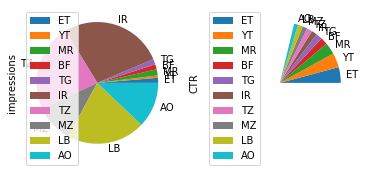

In [21]:
geo_conversions.head(10).plot(kind = 'pie', subplots = True);

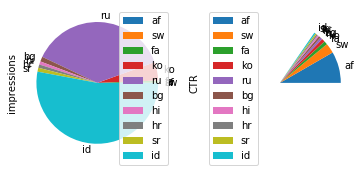

In [22]:
lang_conversions.head(10).plot(kind = 'pie', subplots = True);

In [23]:
source_df.groupby('zone_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'impressions', ascending = False).head(20)

,conversions,impressions,CTR
zone_id,,,
11164447.0,142.0,120157.0,0.001245
13732852.0,71.0,114282.0,0.000623
13014907.0,147.0,64538.0,0.002323
8824465.0,65.0,47960.0,0.001830
8811710.0,258.0,40941.0,0.006353
5388033.0,56.0,39744.0,0.001204
10417508.0,109.0,39139.0,0.002825
10418061.0,57.0,36681.0,0.001526
1667935.0,151.0,35785.0,0.004602


In [24]:
source_df.groupby('zone_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'CTR', ascending = False).head(20)

,conversions,impressions,CTR
zone_id,,,
14426082.0,15.0,481.0,0.037698
11453624.0,52.0,1391.0,0.036422
11141690.0,11.0,333.0,0.030303
14907912.0,82.0,3202.0,0.024745
10006945.0,46.0,2447.0,0.019168
14419947.0,5.0,292.0,0.019011
13833194.0,30.0,1956.0,0.015736
13111574.0,12.0,769.0,0.015645
13212159.0,3.0,263.0,0.011628


In [25]:
source_df.groupby('affiliate_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'impressions', ascending = False).head(20)

,conversions,impressions,CTR
affiliate_id,,,
3927.0,142.0,120157.0,0.001245
6530828.0,71.0,114282.0,0.000623
25560.0,147.0,64538.0,0.002323
4219118.0,65.0,47960.0,0.001830
4214044.0,258.0,40941.0,0.006353
62457.0,56.0,39744.0,0.001204
24291.0,109.0,39139.0,0.002825
508612.0,57.0,36681.0,0.001526
690594.0,151.0,35785.0,0.004602


In [26]:
source_df.groupby('affiliate_id').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'CTR', ascending = False).head(20)

,conversions,impressions,CTR
affiliate_id,,,
6867504.0,15.0,481.0,0.037698
3437162.0,52.0,1391.0,0.036422
5263467.0,11.0,333.0,0.030303
302628.0,82.0,3202.0,0.024745
4744535.0,46.0,2447.0,0.019168
6727511.0,5.0,292.0,0.019011
5803132.0,30.0,1956.0,0.015736
6250772.0,12.0,769.0,0.015645
6302869.0,3.0,263.0,0.011628


In [27]:
source_df.region_code.value_counts()

25289.0    30300
5.0        26928
726.0      25877
12207.0    23010
9878.0     22366
           ...  
25096.0        1
11841.0        1
24206.0        1
15933.0        1
24961.0        1
Name: region_code, Length: 2362, dtype: int64

In [28]:
source_df.city_code.value_counts()

1184.0      30249
35939.0     21200
2763.0      17717
11938.0     17380
10358.0     11628
            ...  
163415.0        1
168260.0        1
306251.0        1
51796.0         1
159800.0        1
Name: city_code, Length: 39699, dtype: int64

Сравним распределения числовых переменных varp, varpp и varcc с распределением конверсий и показов

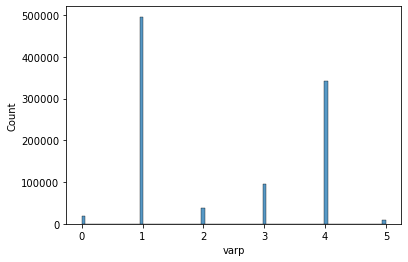

In [29]:
sns.histplot(source_df.varp);

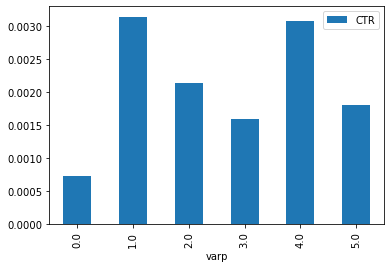

In [30]:
source_df.groupby('varp').aggregate({'CTR' : 'mean'}).plot(kind = 'bar');

In [31]:
source_df.varpp.value_counts()

1.0      360518
2.0      158313
3.0       95933
4.0       64597
5.0       42885
          ...  
971.0         1
973.0         1
977.0         1
981.0         1
624.0         1
Name: varpp, Length: 962, dtype: int64

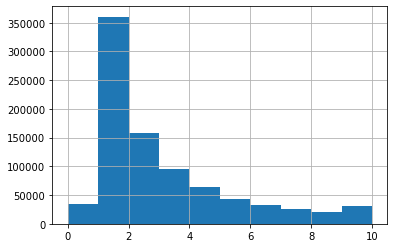

In [32]:
source_df.varpp.hist(range = {0, 10});

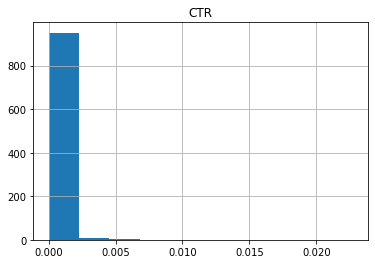

In [33]:
source_df.groupby('varpp').aggregate({'CTR' : 'mean'}).hist();

In [34]:
source_df.varcc.value_counts()

0.0       696504
1.0       114154
2.0        50145
3.0        28565
4.0        18311
           ...  
428.0          1
631.0          1
1309.0         1
633.0          1
849.0          1
Name: varcc, Length: 651, dtype: int64

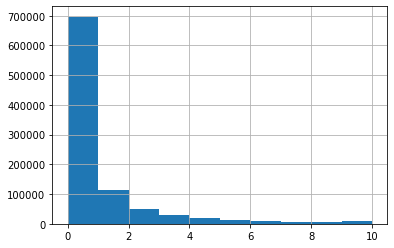

In [35]:
source_df.varcc.hist(range = {0, 10});

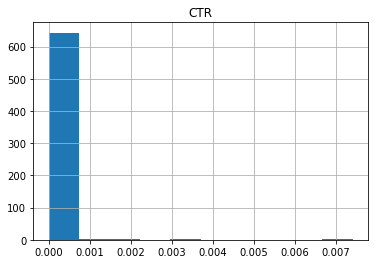

In [36]:
source_df.groupby('varcc').aggregate({'CTR' : 'mean'}).hist();

In [37]:
source_df.groupby('isp').aggregate({'conversions' : 'sum', 'impressions' : 'sum', 'CTR' : 'mean'}).sort_values(by = 'impressions', ascending = False).head(10)

,conversions,impressions,CTR
isp,,,
0.0,260.0,82984.0,0.003052
102851.0,101.0,44790.0,0.002171
92360.0,46.0,36903.0,0.001072
22364.0,76.0,27988.0,0.002754
78476.0,16.0,24366.0,0.000650
102005.0,62.0,23466.0,0.003418
107201.0,60.0,22554.0,0.002666
20939.0,65.0,21613.0,0.002725
38543.0,20.0,20144.0,0.001023


In [38]:
source_df.mobile_isp.value_counts()

0.0       811676
1007.0     13395
1013.0     12876
437.0       9711
434.0       8119
           ...  
539.0          1
1102.0         1
2134.0         1
2143.0         1
1022.0         1
Name: mobile_isp, Length: 433, dtype: int64

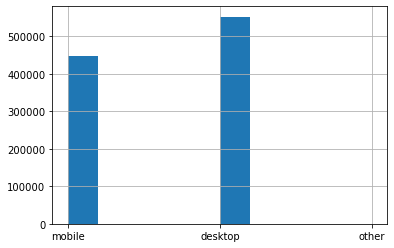

In [39]:
source_df.os_type.hist();

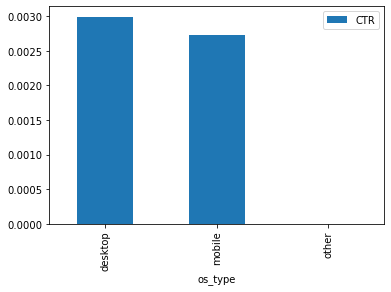

In [40]:
source_df.groupby('os_type').aggregate({'CTR' : 'mean'}).plot(kind = 'bar')

In [41]:
source_df.os.value_counts()

windows          495984
android          343179
ios               95570
mac               38027
other             17441
linux              6012
windows_phone      1835
blackberry         1337
symbian             615
Name: os, dtype: int64

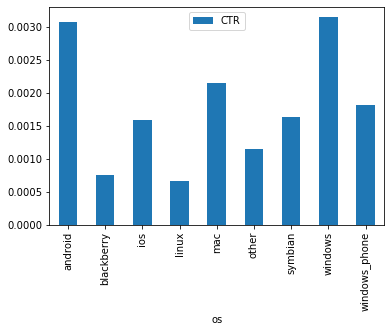

In [42]:
source_df.groupby('os').aggregate({'CTR' : 'mean'}).plot(kind = 'bar')

In [43]:
source_df.os_version.value_counts()

win7              226281
win10             161025
android4          124955
android5          121678
ios9               80154
android6           76348
win8               73859
other              42950
xp                 29339
mac10.11           20395
mac10.10            9924
ios8                7813
vista               5313
ios7                4761
android2            3673
mac10.9             3468
mac10.6             1467
mac10.7             1154
mac10.8             1103
ios5                1044
windows_phone8       927
ios6                 830
ios10                759
mac10.5              256
mac10.12             223
ios4                 132
android3              93
windows_phone7        76
Name: os_version, dtype: int64

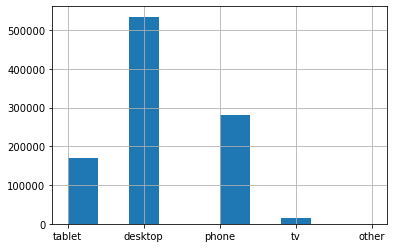

In [44]:
source_df.device_type.hist();

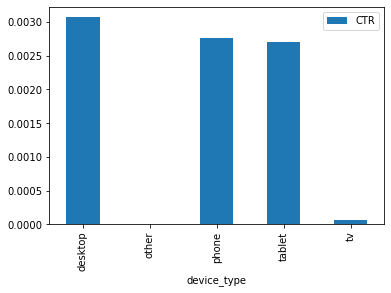

In [45]:
source_df.groupby('device_type').aggregate({'CTR' : 'mean'}).plot(kind = 'bar')

In [46]:
source_df.browser.value_counts()

chrome        613545
safari         90960
firefox        83981
fb             68012
ie             32203
native         26826
edge           25950
opera_mini     20976
uc             17707
other          10659
opera           8746
yandex           291
puffin           144
Name: browser, dtype: int64

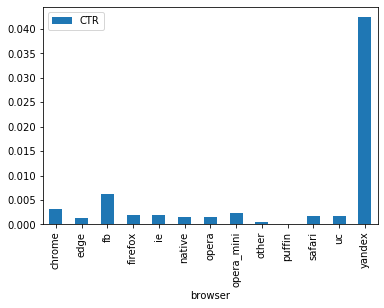

In [47]:
source_df.groupby('browser').aggregate({'CTR' : 'mean'}).plot(kind = 'bar')

In [48]:
source_df.netspeed.value_counts()

BROADBAND    497959
MOBILE       188324
XDSL         177972
CABLE        119560
WIRELESS       9282
DIALUP         4203
SATELLITE      1515
T1             1115
-                67
T3                3
Name: netspeed, dtype: int64

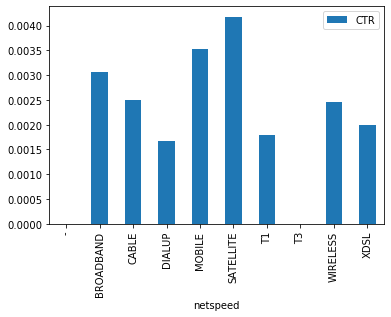

In [49]:
source_df.groupby('netspeed').aggregate({'CTR' : 'mean'}).plot(kind = 'bar')

Дату, время (час) и день недели выделим в отдельные фичи:

In [50]:
source_df['date_time'] =  pd.to_datetime(source_df['date_time'], infer_datetime_format=True, errors ='coerce')

source_df["date"] = source_df["date_time"].dt.date
source_df["hour"] = source_df["date_time"].dt.hour
source_df["day_of_week"] = source_df["date_time"].dt.dayofweek

source_df = source_df.drop(columns=['date_time'])
source_df.head()

,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions,CTR,date,hour,day_of_week
0,23051597.0,502713.0,492.0,4375553.0,2505762.0,BR,726.0,4162.0,4.0,mobile,android,android5,tablet,other,fb,pt,1.0,0.0,17111.0,0.0,f,BROADBAND,1.0,0.0,0.0,2016-09-09,10.0,4.0
1,23075994.0,8508.0,2287.0,13732852.0,6530828.0,RO,12074.0,512299.0,1.0,desktop,windows,win7,desktop,desktop,chrome,ro,2.0,0.0,88118.0,0.0,f,BROADBAND,1.0,0.0,0.0,2016-09-05,14.0,0.0
2,21359300.0,17528.0,NaN,12242731.0,5797966.0,EG,25295.0,29514.0,4.0,mobile,android,android6,tablet,other,chrome,en,6.0,0.0,102851.0,0.0,f,BROADBAND,1.0,0.0,0.0,2016-09-08,22.0,3.0
3,23074678.0,420481.0,2287.0,5388033.0,62457.0,JO,25649.0,12381.0,1.0,desktop,windows,win8,desktop,desktop,ie,en,2.0,0.0,105638.0,0.0,f,BROADBAND,1.0,0.0,0.0,2016-09-10,19.0,5.0
4,22289011.0,450621.0,NaN,11164447.0,3927.0,BR,10122.0,11105.0,1.0,desktop,windows,win10,desktop,desktop,chrome,pt,2.0,0.0,104045.0,0.0,f,BROADBAND,1.0,0.0,0.0,2016-09-14,0.0,2.0


In [51]:
source_df.hour.value_counts()

14.0    50721
11.0    49777
13.0    49424
15.0    49165
12.0    49152
9.0     48480
10.0    48021
16.0    47589
8.0     46281
17.0    45955
18.0    44568
7.0     44268
19.0    44127
20.0    41918
6.0     40005
21.0    38267
5.0     35745
22.0    34241
4.0     34130
1.0     32659
2.0     32588
3.0     32191
23.0    31733
0.0     28995
Name: hour, dtype: int64

In [52]:
source_df.date.value_counts()

2016-09-03    84689
2016-09-11    82200
2016-09-10    78917
2016-09-04    77956
2016-09-05    77230
2016-09-06    70444
2016-09-02    69716
2016-09-07    67038
2016-09-09    66912
2016-09-08    66699
2016-09-14    62848
2016-09-12    62350
2016-09-15    62136
2016-09-13    61257
2016-09-16     9608
Name: date, dtype: int64

Посмотрим на распределение конверсий и показов в зависимости от времени суток:

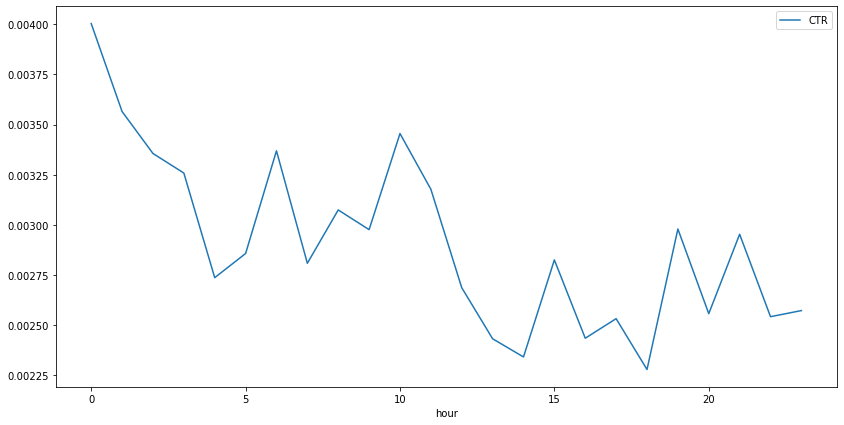

In [53]:
source_df.groupby('hour').agg({'CTR' : 'mean'}).plot(figsize=(14,7));

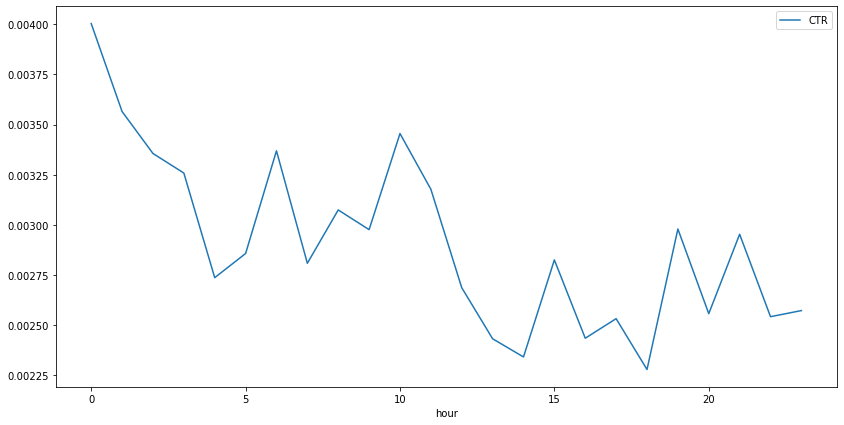

In [54]:
source_df.groupby('hour').agg({'CTR' : 'mean'}).plot(figsize=(14,7));

Проверим, зависит ли распределение показов по времени от местоположения (т.е. указано ли локальное время с учетом часового пояса). Для примера возьмем распределение по США и Индии (по этим странам больше всего записей):

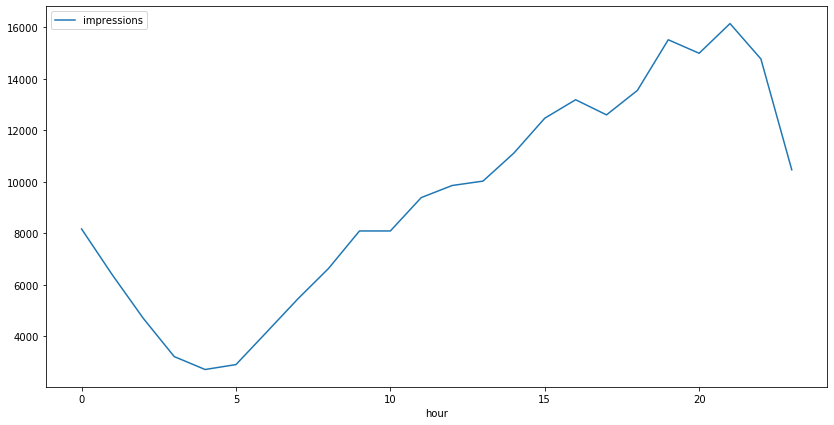

In [55]:
source_df.loc[source_df.geo == 'US'].groupby('hour').agg({'impressions': 'sum'}).plot(figsize=(14,7));

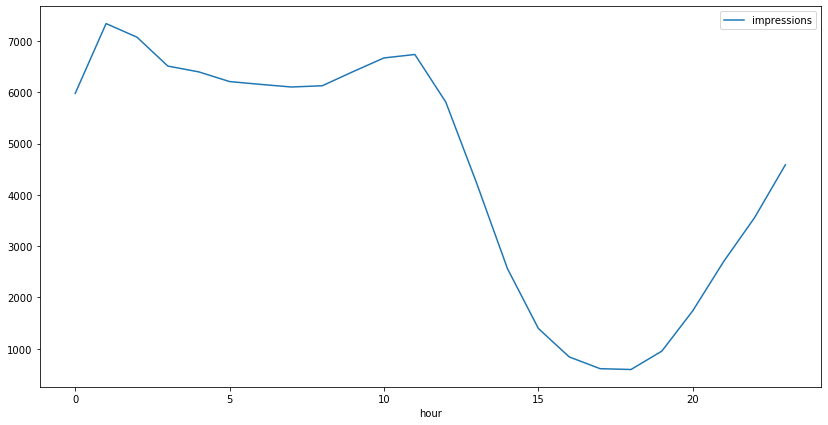

In [56]:
source_df.loc[source_df.geo == 'IN'].groupby('hour').agg({'impressions': 'sum'}).plot(figsize=(14,7));

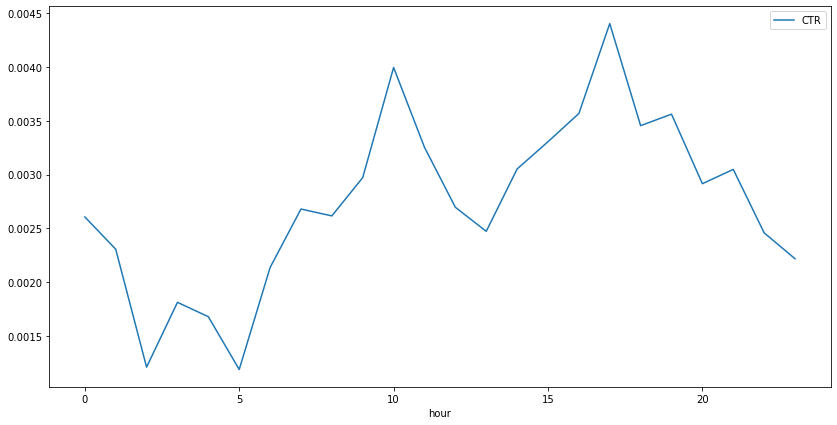

In [57]:
source_df.loc[source_df.geo == 'US'].groupby('hour').agg({'CTR' : 'mean'}).plot(figsize=(14,7));

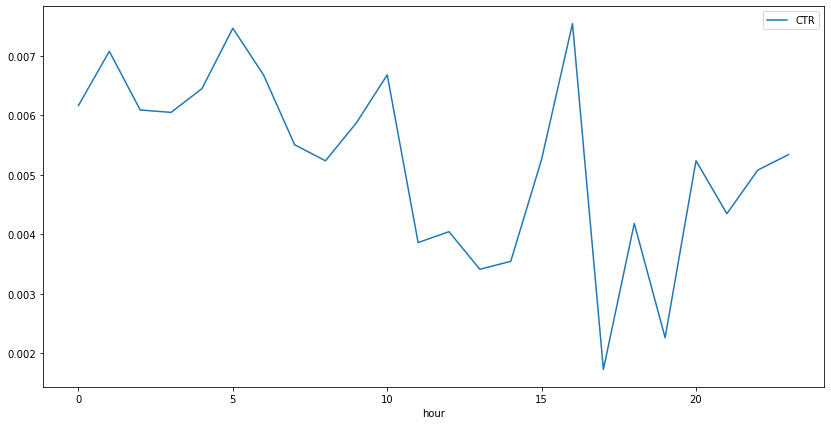

In [58]:
source_df.loc[source_df.geo == 'IN'].groupby('hour').agg({'CTR' : 'mean'}).plot(figsize=(14,7));

Как видно из графиков, пик в США приходится на вечернее время, в Индии - на утреннее. Очень похоже, что в данных не учитывается часовой пояс.

Теперь посмотрим на распределение в зависимости от дня недели:

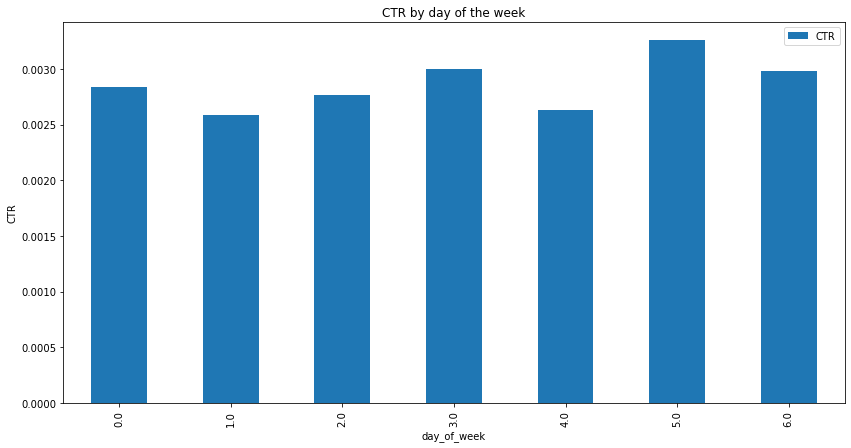

In [59]:
source_df.groupby('day_of_week').agg({'CTR' : 'mean'}).plot(kind='bar', figsize=(14,7));
plt.title('CTR by day of the week');
plt.ylabel('CTR');

Добавим колонки для представления циклической переменной hour

In [60]:
source_df['hour_sin'] = np.sin(2 * np.pi * source_df['hour']/23.0)
source_df['hour_cos'] = np.cos(2 * np.pi * source_df['hour']/23.0)

Удалим из датасета колонку offer_id (в больше чем 60% строк offer_id не указан), затем удалим оставшиеся строки с пустыми значениями.
Представим задачу как классификацию с soft labels

In [61]:
df_preproc = source_df.drop(columns=['offer_id', 'conversions', 'impressions', 'hour'])
df_preproc = df_preproc.dropna()
df_preproc['clicked'] = df_preproc.CTR > 0
df_preproc = df_preproc.drop(columns=['CTR'])
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999926 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   banner_id      999926 non-null  float64
 1   advertiser_id  999926 non-null  float64
 2   zone_id        999926 non-null  float64
 3   affiliate_id   999926 non-null  float64
 4   geo            999926 non-null  object 
 5   region_code    999926 non-null  float64
 6   city_code      999926 non-null  float64
 7   varp           999926 non-null  float64
 8   os_type        999926 non-null  object 
 9   os             999926 non-null  object 
 10  os_version     999926 non-null  object 
 11  device_type    999926 non-null  object 
 12  device         999926 non-null  object 
 13  browser        999926 non-null  object 
 14  lang           999926 non-null  object 
 15  varpp          999926 non-null  float64
 16  varcc          999926 non-null  float64
 17  isp            999926 non-nul

Данные почти полностью состоят из категориальных фич (единственные не категориальные признаки - varp, varpp, varcc, impressions, conversions). При этом, многие фичи (например такие, как banner_id) имеют тысячи уникальных значений.

Для оценки важности признаков сделаем 2 модели: на основе градиентного бустинга (catboost) и на основе глубоких нейронных сетей (модель FiBiNET: Combining Feature Importance and Bilinear feature Interaction for Click-Through Rate Prediction - https://arxiv.org/pdf/1905.09433.pdf)

В первом случае для обработки категориальных фич применим стандартный метод catboost (ordered target encoding), во втором - захэшируем категориальные фичи (feature hashing), а численные фичи нормализуем.

In [62]:
categorical_features = [
    'banner_id', 'advertiser_id', 'affiliate_id', 'zone_id', 
    'day_of_week', 
    'os', 'os_type', 'os_version', 
    'geo', 'region_code', 'city_code', 
    'device_type', 'device', 'browser', 'netspeed', 'proxy',
    'isp', 'mobile_isp', 'date'
]

numeric_features = ['varp', 'varpp', 'varcc', 'hour_sin', 'hour_cos']

for col in df_preproc.columns:
    if col in categorical_features:
        df_preproc[col] = df_preproc[col].astype('string')

Временно упростим задачу и представим как задачу классификации (кликнули или нет)

In [63]:
features = categorical_features + numeric_features
target = 'clicked'
#target = 'CTR'
df = df_preproc[features + [target]]

In [64]:
df_train, df_test = train_test_split(df, random_state=0)

df_train.head()

cat_features_indices = [df.columns.get_loc(c) for c in categorical_features if c in df]

В качестве функции потерь выберем Logloss и установим веса классов (auto_class_weights = 'Balanced'), чтобы модель смогла распознавать минорный класс.

In [65]:
train_pool = Pool(df_train[features].values, label=df_train[target],
                  cat_features=cat_features_indices)
test_pool = Pool(df_test[features].values, label=df_test[target],
                 cat_features=cat_features_indices)

model = CatBoostClassifier(
    loss_function = 'Logloss', 
    #loss_function = 'CrossEntropy',
    iterations = 30,
    auto_class_weights = 'Balanced',
    verbose = 1
)

In [66]:
model.fit(train_pool)

Learning rate set to 0.5
0:	learn: 0.6285017	total: 713ms	remaining: 20.7s
1:	learn: 0.6142187	total: 1.08s	remaining: 15.2s
2:	learn: 0.5877737	total: 1.51s	remaining: 13.6s
3:	learn: 0.5755963	total: 1.94s	remaining: 12.6s
4:	learn: 0.5718535	total: 2.22s	remaining: 11.1s
5:	learn: 0.5702807	total: 2.56s	remaining: 10.3s
6:	learn: 0.5666761	total: 2.97s	remaining: 9.75s
7:	learn: 0.5636046	total: 3.37s	remaining: 9.27s
8:	learn: 0.5631297	total: 3.67s	remaining: 8.56s
9:	learn: 0.5570954	total: 4.08s	remaining: 8.15s
10:	learn: 0.5564368	total: 4.29s	remaining: 7.42s
11:	learn: 0.5538446	total: 4.66s	remaining: 7s
12:	learn: 0.5533925	total: 4.97s	remaining: 6.5s
13:	learn: 0.5510300	total: 5.42s	remaining: 6.19s
14:	learn: 0.5501632	total: 5.79s	remaining: 5.79s
15:	learn: 0.5482586	total: 6.2s	remaining: 5.42s
16:	learn: 0.5482496	total: 6.46s	remaining: 4.94s
17:	learn: 0.5481573	total: 6.64s	remaining: 4.43s
18:	learn: 0.5471313	total: 7.04s	remaining: 4.08s
19:	learn: 0.5454331	

In [67]:
# make the prediction using the resulting model
preds = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
print("predictions = ", preds)
print("predictions proba = ", preds_proba)

predictions =  ['False' 'False' 'False' ... 'False' 'False' 'False']
predictions proba =  [[0.97795938 0.02204062]
 [0.85802814 0.14197186]
 [0.79533414 0.20466586]
 ...
 [0.50452659 0.49547341]
 [0.88698209 0.11301791]
 [0.98770408 0.01229592]]


In [68]:
np.unique(preds, return_counts = True)

(array(['False', 'True'], dtype=object), array([165329,  84653], dtype=int64))

In [69]:
metrics = model.eval_metrics(
    data=test_pool,
    metrics=['F1','AUC', 'Precision', 'Recall'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Feature ranking:
1. feature advertiser_id (18.261752)
2. feature varcc (13.518519)
3. feature varpp (10.486788)
4. feature device_type (8.383047)
5. feature geo (6.322329)
6. feature affiliate_id (6.271667)
7. feature zone_id (6.060731)
8. feature banner_id (5.259306)
9. feature browser (4.748864)
10. feature varp (3.898311)
11. feature device (3.414340)
12. feature os (2.407085)
13. feature day_of_week (2.027997)
14. feature mobile_isp (1.922725)
15. feature hour_sin (1.809317)
16. feature hour_cos (1.668540)
17. feature city_code (1.352763)
18. feature os_version (1.130274)
19. feature region_code (0.554923)
20. feature date (0.384773)
21. feature netspeed (0.099505)
22. feature proxy (0.016400)
23. feature os_type (0.000044)
24. feature isp (0.000000)


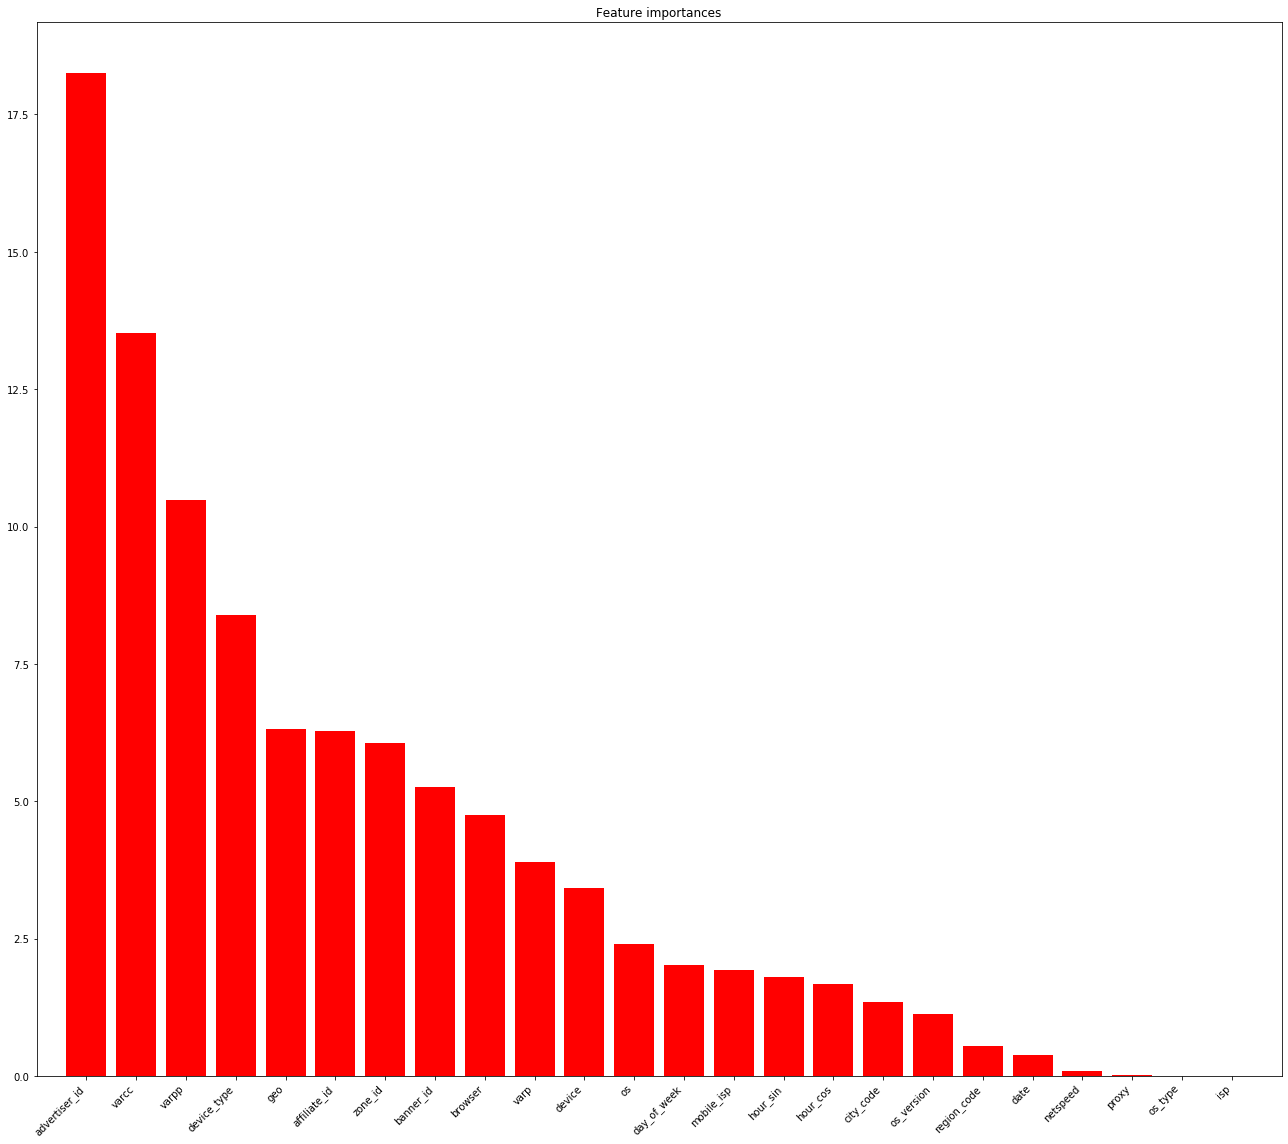

In [70]:
def plot_feature_importance(X, model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    labels = []
    for indice in indices:
        labels.append(feature_names[indice])

    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(18, 16))
    plt.title("Feature importances")
    plt.bar(range((X.shape[1])), importances[indices],
            color="r", 
            #yerr=std[indices],
            align="center")

    plt.xticks(range(X.shape[1]), labels, rotation = 45, ha='right')
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(df[features], model, features)

Теперь построим модель на основе нейросети FiBiNET (показала одни из лучших результатов для предсказания CTR на известных бенчмарках)

In [71]:
target = ['clicked']
df2 = df_preproc

In [72]:
# 1.do simple Transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
df2[numeric_features] = mms.fit_transform(df2[numeric_features])

# 2.set hashing space for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=1000,embedding_dim=4, use_hash=True, dtype='string')  # since the input is string
                          for feat in categorical_features] + [DenseFeat(feat, 1,)
                          for feat in numeric_features]

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns, )

# 3.generate input data for model

train, test = train_test_split(df2, test_size=0.2, random_state=0)

train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}


# 4.Define Model,train,predict and evaluate
model = FiBiNET(linear_feature_columns,dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=3, verbose=2, validation_split=0.2, )


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'senet_layer/W_1:0' shape=(19, 6) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 1/3
2500/2500 - 216s - loss: 0.0257 - binary_crossentropy: 0.0250 - val_loss: 0.0210 - val_binary_crossentropy: 0.0202
Epoch 2/3
2500/2500 - 182s - loss: 0.0197 - binary_crossentropy: 0.0188 - val_loss: 0.0211 - val_binary_crossentropy: 0.0202
Epoch 3/3
2500/2500 - 182s - loss: 0.0193 - binary_crossentropy: 0.0183 - val_loss: 0.0213 - val_binary_crossentropy: 0.0203


In [73]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.0186
test AUC 0.7922


In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
banner_id (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
advertiser_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
affiliate_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
zone_id (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

Для оценки важности фич по модели нейросети применим метод permutation feature importance (немного подкорректируем реализацию метода из библиотеки eli5, чтобы она подходила для модели на основе tensorflow):

In [75]:
from __future__ import absolute_import
from typing import Tuple, List, Callable, Any

import numpy as np
from sklearn.utils import check_random_state


def iter_shuffled(X, columns_to_shuffle=None):

    X_res = X.copy()
    for column in columns_to_shuffle:
        print("shufflin " + column)
        print(X_res[column].head(5))
        X_res[column] = np.random.permutation(X_res[column].values) 
        print(X_res[column].head(5))
        yield X_res        
        X_res[column] = X[column]


def get_score_importances(
        score_func,  
        X,
        y,        
        columns_to_shuffle,
        n_iter=3
    ):
    
    base_score = score_func(X, y)
    scores_decreases = []
    for i in range(n_iter):
        scores_shuffled = _get_scores_shufled(
            score_func, X, y, columns_to_shuffle=columns_to_shuffle
        )
        scores_decreases.append(-scores_shuffled + base_score)
    return base_score, scores_decreases


def _get_scores_shufled(score_func, X, y, columns_to_shuffle):
    Xs = iter_shuffled(X, columns_to_shuffle)
    scores = []
    for X_shuffled in Xs:
        score = score_func(X_shuffled, y)
        print(score)
        scores.append(score)        
        
    return np.array(scores)


In [76]:
def score(X, y):
    X = {name:X[name] for name in feature_names}
    y_pred = model.predict(X, batch_size=256)
    return roc_auc_score(y, y_pred)


base_score, score_decreases = get_score_importances(score, test[feature_names], test[target].values, feature_names)
feature_importances = np.mean(score_decreases, axis=0)

shufflin banner_id
978119    22828200.0
296700    23933056.0
266171    17125446.0
302756    23735820.0
36241     24067040.0
Name: banner_id, dtype: string
978119    22731660.0
296700    23748202.0
266171    24161155.0
302756    23339150.0
36241     23074678.0
Name: banner_id, dtype: object
0.76722036318251
shufflin advertiser_id
978119    305078.0
296700    601829.0
266171    322803.0
302756    420481.0
36241     356294.0
Name: advertiser_id, dtype: string
978119    348979.0
296700    510690.0
266171    336221.0
302756    322803.0
36241     500736.0
Name: advertiser_id, dtype: object
0.7282513696338371
shufflin affiliate_id
978119    3990447.0
296700      62457.0
266171       3927.0
302756      25560.0
36241     4035630.0
Name: affiliate_id, dtype: string
978119    4035630.0
296700    3990447.0
266171    5720549.0
302756    5288251.0
36241     4214044.0
Name: affiliate_id, dtype: object
0.7621945635908622
shufflin zone_id
978119    13362317.0
296700     5388033.0
266171    11164447.0
3

0.7920091552739317
shufflin os_type
978119     mobile
296700    desktop
266171    desktop
302756    desktop
36241     desktop
Name: os_type, dtype: string
978119    desktop
296700     mobile
266171    desktop
302756     mobile
36241      mobile
Name: os_type, dtype: object
0.7921438790336858
shufflin os_version
978119    android5
296700        win7
266171       win10
302756        win8
36241         win7
Name: os_version, dtype: string
978119    android4
296700          xp
266171        win7
302756       other
36241        win10
Name: os_version, dtype: object
0.7892385975393471
shufflin geo
978119    BR
296700    TN
266171    CO
302756    ID
36241     HU
Name: geo, dtype: string
978119    US
296700    SA
266171    FR
302756    IN
36241     SE
Name: geo, dtype: object
0.78507956475313
shufflin region_code
978119    23777.0
296700    26061.0
266171    11647.0
302756    11800.0
36241     11775.0
Name: region_code, dtype: string
978119       55.0
296700        6.0
266171       44.0
302756

0.7917349969292011
shufflin device
978119      other
296700    desktop
266171    desktop
302756    desktop
36241     desktop
Name: device, dtype: string
978119    desktop
296700    desktop
266171    desktop
302756    desktop
36241     desktop
Name: device, dtype: object
0.7865770939482502
shufflin browser
978119    chrome
296700    chrome
266171    chrome
302756    chrome
36241     chrome
Name: browser, dtype: string
978119    chrome
296700    chrome
266171    native
302756        ie
36241     chrome
Name: browser, dtype: object
0.7787406549682704
shufflin netspeed
978119    BROADBAND
296700    BROADBAND
266171    BROADBAND
302756       MOBILE
36241     BROADBAND
Name: netspeed, dtype: string
978119       MOBILE
296700    BROADBAND
266171    BROADBAND
302756        CABLE
36241        MOBILE
Name: netspeed, dtype: object
0.7917455493446007
shufflin proxy
978119    f
296700    f
266171    f
302756    f
36241     f
Name: proxy, dtype: string
978119    f
296700    f
266171    f
302756    f

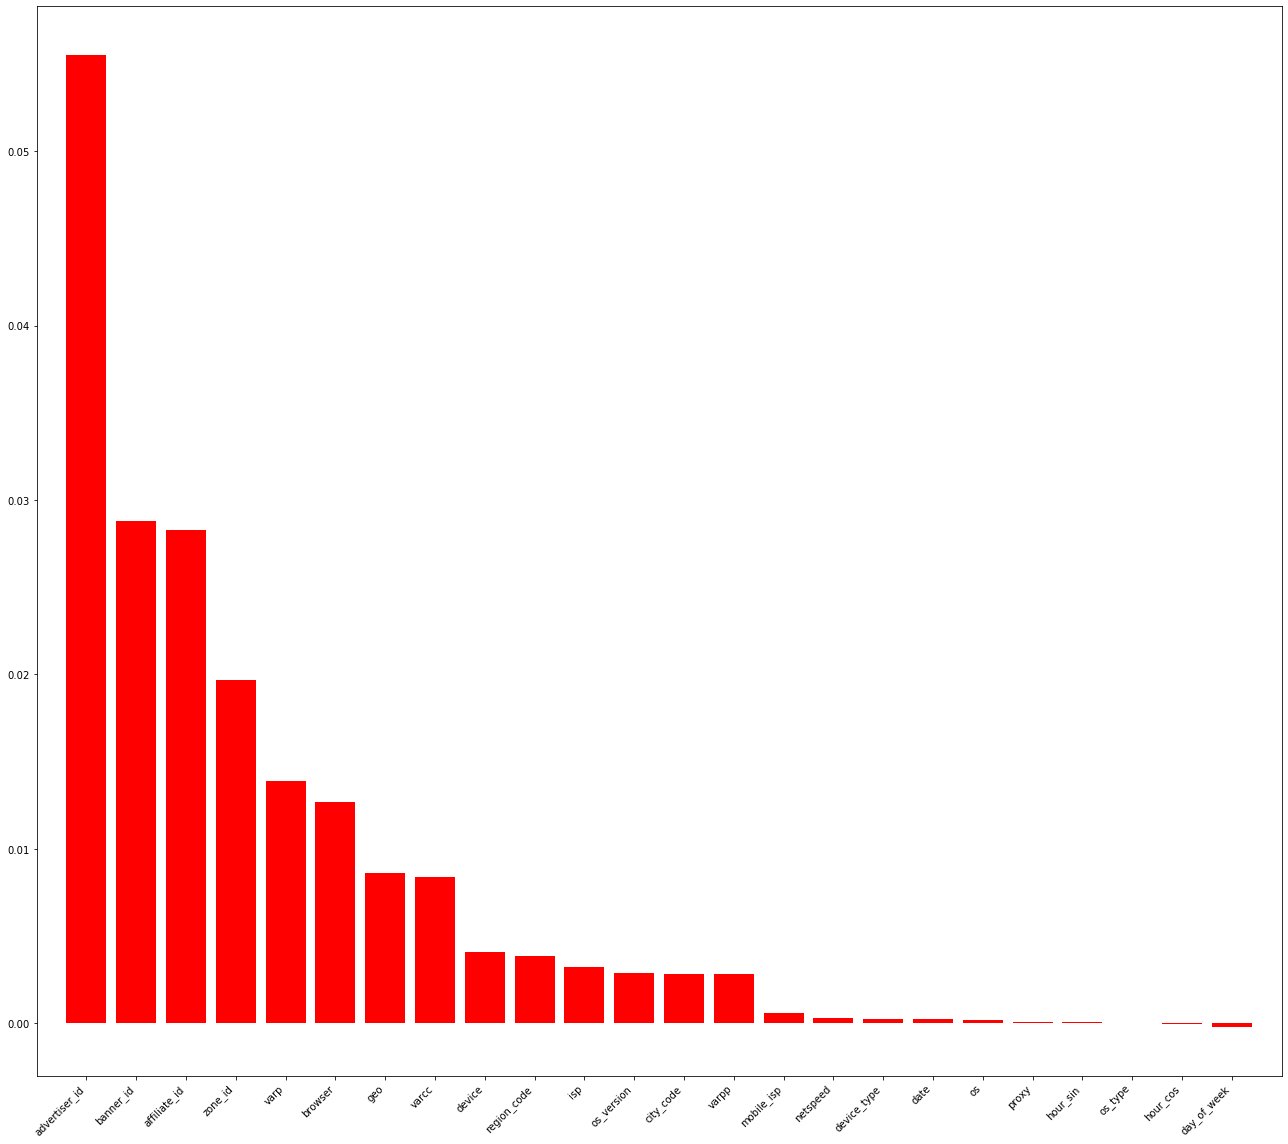

In [77]:
feature_importances_dict = dict(zip(feature_names, feature_importances))
sorted_features = dict(sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse = True))
plt.figure(figsize=(18, 16))
plt.bar(sorted_features.keys(), sorted_features.values(), align="center", color='r')
plt.xticks(range(len(sorted_features)), list(sorted_features.keys()), rotation = 45, ha='right')
plt.xlim([-1, len(sorted_features)])
plt.tight_layout()
plt.show()

1. Попробовать больше методов feature engineering:
    - Взять новые фичи из даты и времени (сделать переменную "время суток" (утро, день, вечер, ночь), сделать переменную day_of_week цикличной по аналогии с hour и т.п.)
    - Решить проблему с часовыми поясами (для этого нужно знать город и время, которое указывается в датасете). 
    - Создать новые фичи на основе взаимодействия признаков
2. Попробовать другие модели (Field-aware factorization machines, DeepFM и др.)
3. Для градиентного бустинга - попробовать другую функцию потерь (cross-entropy с весами вместо logloss), задачу представить как классификацию с soft labels (CTR - как вероятность, которую предсказывает модель).
4. Попробовать сделать отдельные модели в зависимости от региона.
5. Попробовать другие методы обработки категориальных фич в нейросетевой модели (например, target encoding).
6. Оптимизировать гиперпараметры моделей.
7. Попробовать Elapsed-Time Sampling Delayed Feedback Model (ES-DFM) (https://arxiv.org/abs/2012.03245) для решения проблемы с задержкой в получении информации о конверсиях   

Также, нужно предусмотреть появление на данных в production отсутствующих в обучающей выборке данных по banner_id, advertizer_id, affiliate_id и др.